# Plotting predictions from models

In [4]:
import pickle
from revenue.model import TCN
import os
import argparse
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import rc
from revenue.data import RevenueDataset
import numpy as np
import pandas as pd
import datetime

### Styles

In [5]:
cluster_style = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "ytick.left": False,
}
ts_style = {
    "axes.spines.left": True,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": True,
    "ytick.left": True,
}
rc("text", usetex=True)

In [3]:
import os
os.getcwd()

'c:\\Users\\eriko\\OneDrive - NTNU\\ntnu\\fag\\prosjekt\\TCN'

In [19]:
#model_dir = "revenue\models"
model_dir = "Z:\TCN_clone\TCN\\revenue\models"
#model_names = ["test", "test_no_scale"]
model_names = [
    "1ac6826c66f546af9e90ea6aac14aad3",
    "693bd474476a4e0ebbfe8387c8695e7a",
    "c12f774918eb4c809e3c67d87d545df8",
    "9dd49918c3834dfd9916abd926f80e41",
    ]

model_paths = [f"{os.path.join(model_dir, mn)}.pt" for mn in model_names]
model_paths
#Z:\TCN_clone\TCN\revenue\models\1ac6826c66f546af9e90ea6aac14aad3.pt__args

['Z:\\TCN_clone\\TCN\\revenue\\models\\1ac6826c66f546af9e90ea6aac14aad3.pt',
 'Z:\\TCN_clone\\TCN\\revenue\\models\\693bd474476a4e0ebbfe8387c8695e7a.pt',
 'Z:\\TCN_clone\\TCN\\revenue\\models\\c12f774918eb4c809e3c67d87d545df8.pt',
 'Z:\\TCN_clone\\TCN\\revenue\\models\\9dd49918c3834dfd9916abd926f80e41.pt']

In [20]:
models = []
for MODEL_PATH in model_paths:
    args = pickle.load(open(f"{MODEL_PATH}__args.pkl", "rb"))
    print(args)
    model = TCN(
        num_layers=args.num_layers,
        in_channels=1,
        out_channels=1,
        residual_blocks_channel_size=[args.res_block_size]*args.num_layers,
        kernel_size=args.kernel_size,
        bias=args.bias,
        dropout=args.dropout,
        stride=1,
        leveledinit=args.leveledinit,
        embedding_dim=args.embedding_dim,
        embed=args.embed,
        dilated_convolutions=args.dilated_convolutions,
        clustering_dict=None,
    )
    model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
    model.eval()
    models.append(model)

Namespace(N=100, bias=True, clip=True, cluster_covariate=False, cluster_dict_path='None', clustering='KMeans', data_scale=True, dilated_convolutions=False, dropout=0.2, embed=None, embed_sector=False, embedding_dim=3, epochs=100, h_batch_size=4, kernel_size=4, length_rolling=4, leveledinit=True, log_interval=300, lr=0.0005, mean=0, model_save_path='revenue/models/1ac6826c66f546af9e90ea6aac14aad3.pt', num_clusters=10, num_components=10, num_layers=6, num_rolling_periods=2, num_workers=4, one_hot_id=False, print=True, random_covariate=False, representation='pca', res_block_size=16, similarity='euclidean', stride=1, t=1000, tenacity=10, time_covariates=False, train_end='2017-01-01', train_start='2007-01-01', type_res_blocks='erik', v_batch_size=128, var=1.0, writer_path='revenue/runs/1ac6826c66f546af9e90ea6aac14aad3', zero_covariate=False)
[1, 1, 1, 1, 1, 1]
Namespace(N=100, bias=True, clip=True, cluster_covariate=False, cluster_dict_path='None', clustering='KMeans', data_scale=True, dila

## Dataset rolling val

In [28]:
ds_train = RevenueDataset(
        file_path="revenue/data/processed_companies.csv",
        meta_path="revenue/data/comp_sect_meta.csv",
        data_scale=True,
        data_scaler=None,
        start_date="2014-01-01",  # yyyy-mm-dd
        end_date="2017-01-01",  # yyyy-mm-dd,
)
ds_scaled = RevenueDataset(
        file_path="revenue/data/processed_companies.csv",
        meta_path="revenue/data/comp_sect_meta.csv",
        data_scale=True,
        data_scaler=ds_train.data_scaler,
        start_date="2013-12-31",  # yyyy-mm-dd
        end_date="2018-12-31",  # yyyy-mm-dd
)
ds_unscaled = RevenueDataset(
        file_path="revenue/data/processed_companies.csv",
        meta_path="revenue/data/comp_sect_meta.csv",
        data_scale=False,
        data_scaler=ds_train.data_scaler,
        start_date="2013-12-31",  # yyyy-mm-dd
        end_date="2018-12-31",  # yyyy-mm-dd
)

Dimension of X :  torch.Size([15229, 1, 12])
Dimension of Y :  torch.Size([15229, 1, 12])
Dimension of X :  torch.Size([15229, 1, 21])
Dimension of Y :  torch.Size([15229, 1, 21])
Dimension of X :  torch.Size([15229, 1, 21])
Dimension of Y :  torch.Size([15229, 1, 21])


In [42]:
ids = [16, 176, 316]#, 5000, 7000, 10000]
#model = models[0]
mods = [models[1], models[3]]#, models[3]]
names = ["scaling", "leveledinit"]
scale = [True, False]#[True, False]
dfs = []
for i in ids:
    d = {}
    with torch.no_grad():
        #print(ds_scaled.X[i].unsqueeze(1).shape)
        for j, model in enumerate(mods):
            if scale[j]:
                preds, _ = model.rolling_prediction(x=ds_scaled.X[i].unsqueeze(1), emb_id=i, tau=4, num_windows=2)
                #print(preds)
                predictions_rescaled = np.zeros((15229, 2*4))
                predictions_rescaled[i] = preds.cpu().numpy()
                predictions_rescaled = ds_train.data_scaler.inverse_transform(predictions_rescaled.T).T
                predictions = predictions_rescaled[i]
                #print(predictions)
                d[names[j]]=predictions
                #d[f"model{j}"]=preds.detach().cpu().numpy()[0]
            else:
                preds, _ = model.rolling_prediction(x=ds_unscaled.X[i].unsqueeze(1), emb_id=i, tau=4, num_windows=2)
                d[names[j]]=preds.detach().cpu().numpy()[0]
        real_values = ds_unscaled.X[i, 0, -2*4 :].detach().cpu().numpy()
        d["real"] = real_values
        df = pd.DataFrame(d)
        #df.index  = pd.date_range(start="2014-12-16", freq='H', periods=24*7)
        dfs.append(df)

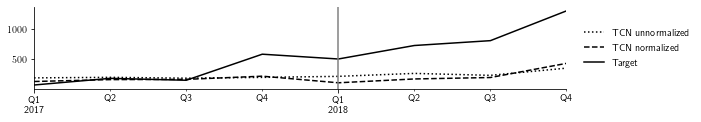

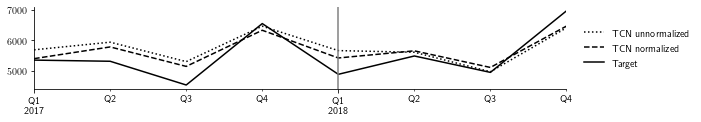

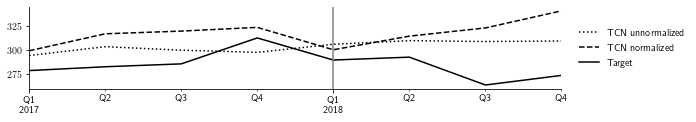

In [45]:
plot_length = 8
with plt.style.context(ts_style):
    for i in range(len(ids)): 
        date_list = ds_unscaled.dates.tolist()
        dfs[i].index = pd.to_datetime(date_list[-2*4:])
        ax = dfs[i][-plot_length:].plot(figsize=(2*4.77, 1.5), color=['k', 'k', 'k'], style=[':', '--', '-'], legend=names)
        
        x = pd.to_datetime(['2018-03-31'])
        for xc in x:
            ax.axvline(x=xc, color='grey', linestyle='-')
        #x1, x2 = ax.get_xlim()
        #ax.set_xlim((x1, x2 + 1))
        ax.legend(["TCN unnormalized", "TCN normalized", "Target"], loc=7, frameon=False, bbox_to_anchor=(1.25, 0.5))
        plt.savefig(f"Figures\\revenue_simple_pred_id_{ids[i]}.pdf", bbox_inches="tight")

# Embedding

In [10]:
model_dir = "Z:\TCN_clone\TCN\\revenue\models"
model_names = [
    "tcn_3_4_32_False_embed_True_dim_5",
]
model_paths = [f"{os.path.join(model_dir, mn)}" for mn in model_names]
model_paths

['Z:\\TCN_clone\\TCN\\revenue\\models\\tcn_3_4_32_False_embed_True_dim_5']

In [13]:
models = []
for MODEL_PATH in model_paths:
    #args = pickle.load(open(f"{MODEL_PATH}__args.pkl", "rb"))
    model = TCN(
        num_layers=3,#args.num_layers,
        in_channels=1,
        out_channels=1,
        residual_blocks_channel_size=[32]*3,#[args.res_block_size]*args.num_layers,
        kernel_size=4,#args.kernel_size,
        bias=True,#args.bias,
        dropout=0.2,#args.dropout,
        stride=1,
        leveledinit=False,#args.leveledinit,
        num_embeddings=15299,
        embedding_dim=5,#args.embedding_dim,
        embed="post",#args.embed,
        dilated_convolutions=False
    )
    model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
    model.eval()
    models.append(model)
#print(models)

[1, 1, 1]


RuntimeError: Error(s) in loading state_dict for TCN:
	size mismatch for embedding.weight: copying a param with shape torch.Size([15229, 5]) from checkpoint, the shape in current model is torch.Size([15299, 5]).

## Embedding layer of each model

In [ ]:
embeddings = []
for model in models:
    ids = [i for i in range(370)]
    ids = torch.LongTensor(ids).to("cpu")
    embds = model.embedding(ids).detach().cpu().numpy()
    embeddings.append(embds)

## Visualize

In [ ]:
with plt.style.context(cluster_style):
    for embedding in embeddings[:2]:
        nc = embedding.shape[1]
        if embedding.shape[1] > 2:
            tsne = TSNE(n_components=2)
            embedding = tsne.fit_transform(embedding)
        #plt.figure()
        #plt.scatter(embedding[:,0], embedding[:,1], c="#00B0F0", edgecolor="black", linewidth=0.5)
        #plt.title(f"Embedding dim {nc}")
        #plt.show()
#"colors = ["#FFC000", "#00B0F0"]ø

In [ ]:
size=4.77/3
with plt.style.context(cluster_style):
    plt.figure(figsize=(size, size))
    plt.scatter(embeddings[0][:,0], embeddings[0][:,1], s=20, c="#00B0F0", edgecolor="black", linewidth=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.axis('scaled')
    #plt.title(f"Embedding dim {nc}")
    plt.savefig("electricity_learned_embedding_2.pdf")#, bbox_inches="tight")
    for embedding in embeddings[:2]:
        nc = embedding.shape[1]
        tsne = TSNE(n_components=2)
        embedding = tsne.fit_transform(embedding)
        plt.figure(figsize=(size, size))
        plt.scatter(embedding[:,0], embedding[:,1], s=20, c="#00B0F0", edgecolor="black", linewidth=0.3)
        plt.xticks([])
        plt.yticks([])
        plt.axis('scaled')
        #plt.title(f"Embedding dim {nc}")
        plt.savefig(f"electricity_learned_embedding_{nc}_tsne.pdf")#, bbox_inches="tight")